# Forecast energy consumption

In [59]:
!pip install xgboost 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns 
from tqdm import tqdm 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

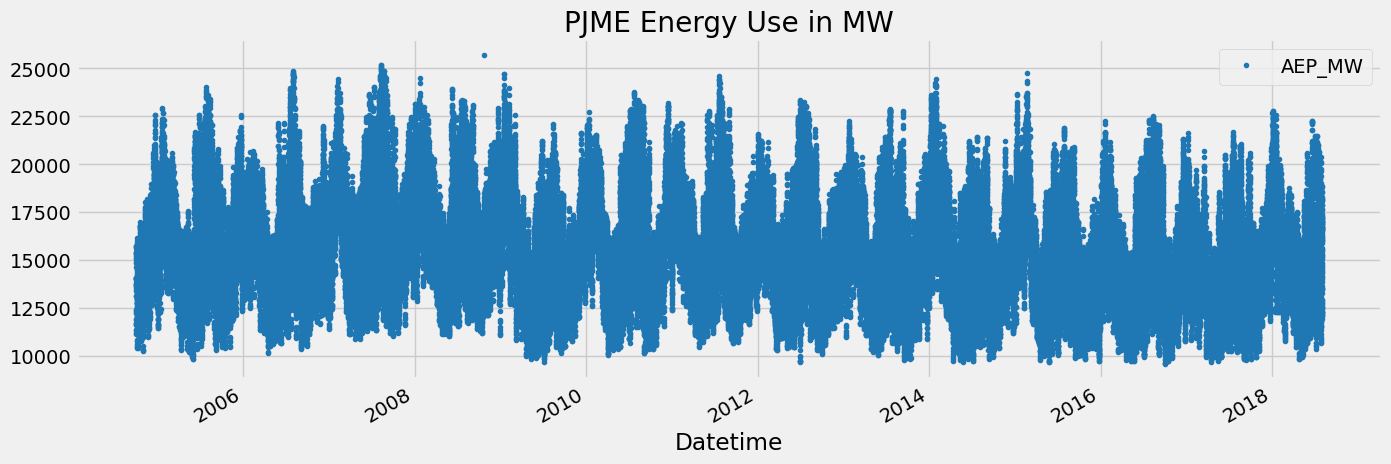

In [11]:
dossier = '/Users/augustincablant/Desktop/Kaggle/'

df = pd.read_csv(dossier+'AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

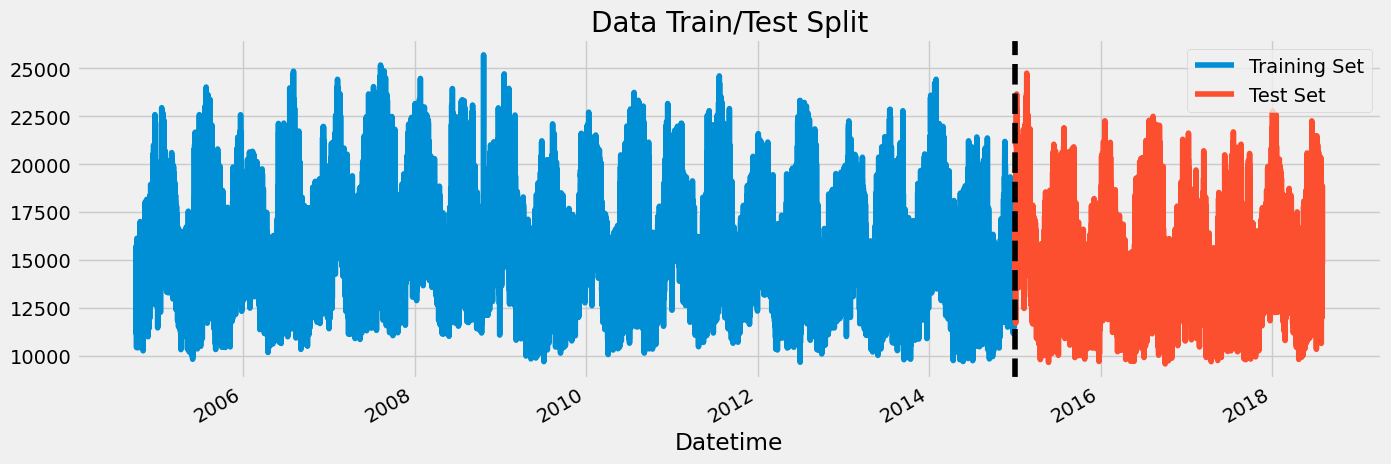

In [23]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Feature creation

In [26]:
def feature_creation(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = feature_creation(df)
df.head()

,AEP_MW,hour,dayofweek,dayofyear,quarter,day,month,year,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,366,4,31,12,2004,53
2004-12-31 02:00:00,12865.0,2,4,366,4,31,12,2004,53
2004-12-31 03:00:00,12577.0,3,4,366,4,31,12,2004,53
2004-12-31 04:00:00,12517.0,4,4,366,4,31,12,2004,53
2004-12-31 05:00:00,12670.0,5,4,366,4,31,12,2004,53


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


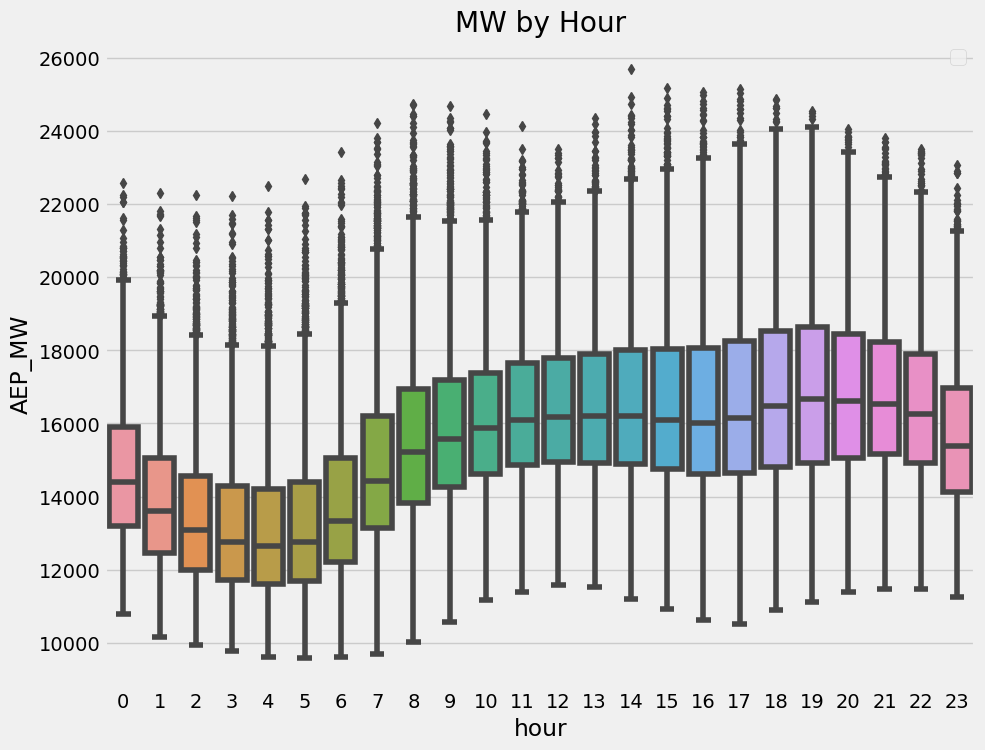

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

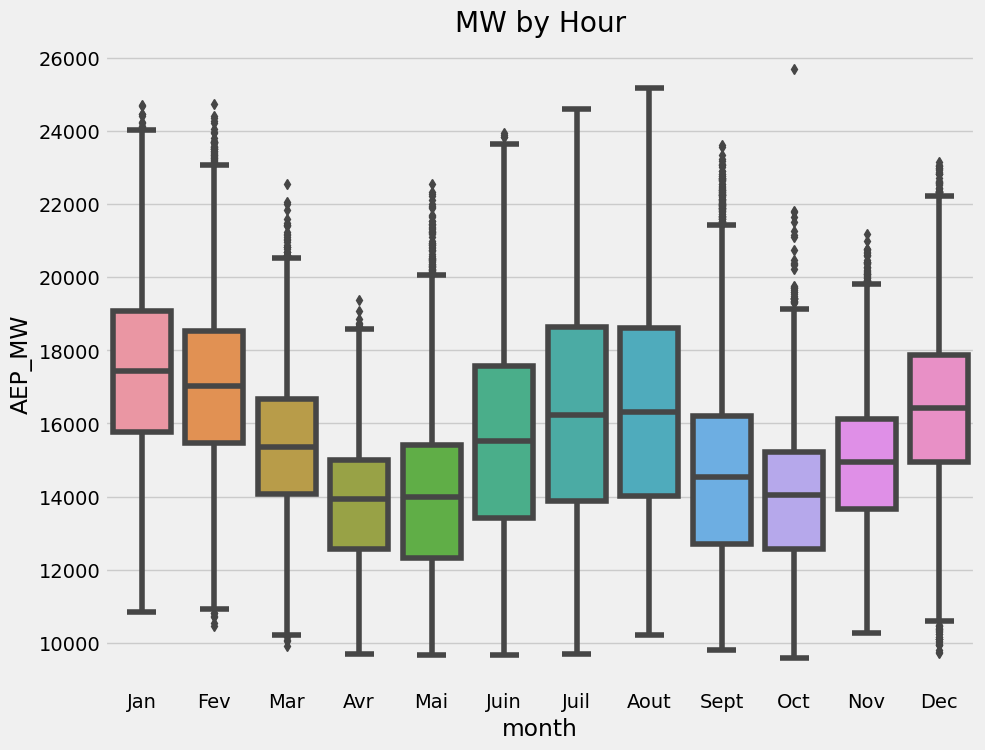

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW')
mois_labels = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aout', 'Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(range(12), mois_labels)
ax.set_title('MW by Hour')
plt.show()

create our model

In [36]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']


FEATURES = ['hour', 'dayofweek', 'dayofyear', 'quarter', 'day', 'month',
       'year']
TARGET = 'AEP_MW'

X_train, X_test, y_train, y_test = train[FEATURES], test[FEATURES], train[TARGET], test[TARGET]

model = XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

model.fit(X_train, y_train, 
eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:03:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15793.26062	validation_1-rmse:14861.30187
[100]	validation_0-rmse:6033.90962	validation_1-rmse:5144.92812
[200]	validation_0-rmse:2702.81824	validation_1-rmse:2157.90852
[300]	validation_0-rmse:1753.93080	validation_1-rmse:1665.67943
[392]	validation_0-rmse:1525.27669	validation_1-rmse:1654.77106


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

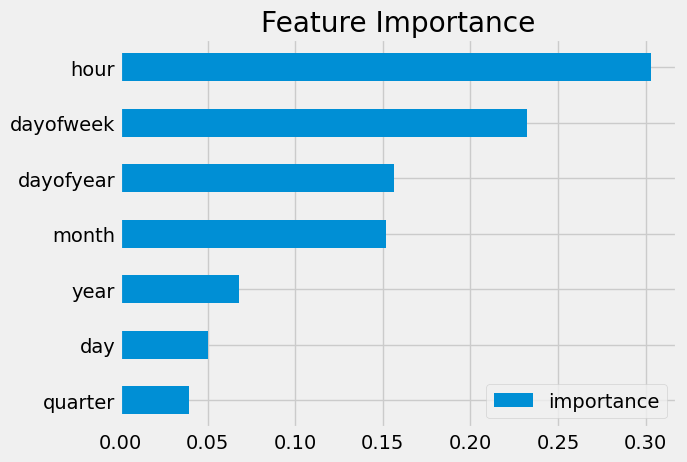

In [43]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_1590/1867864733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(X_test)


<Figure size 1600x800 with 0 Axes>

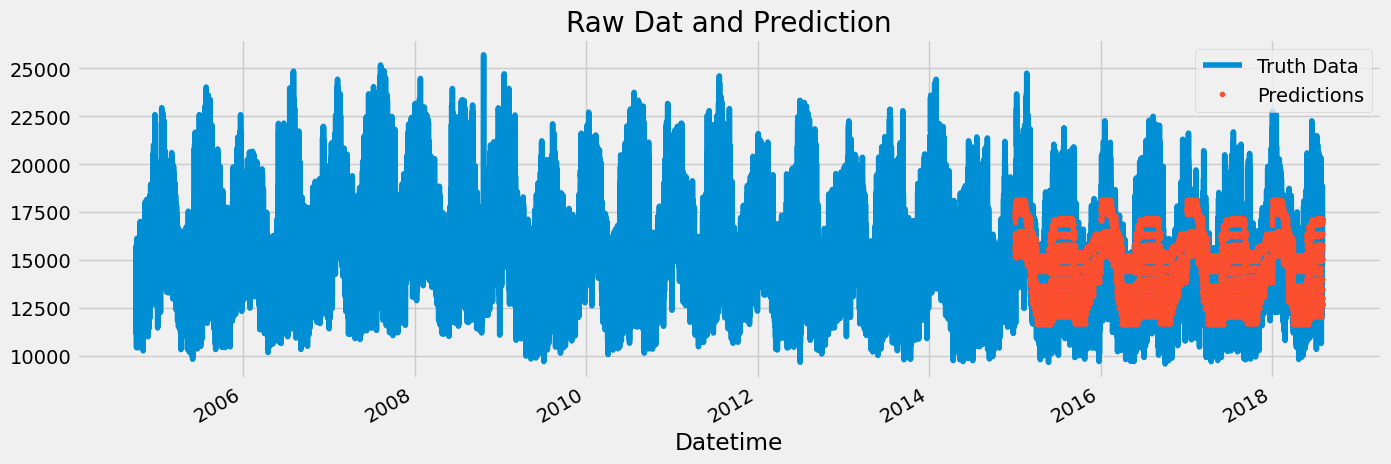

In [52]:
test['prediction'] = model.predict(X_test)

plt.figure(figsize = (16,8))
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


In [55]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1648.00


More complex analysis !

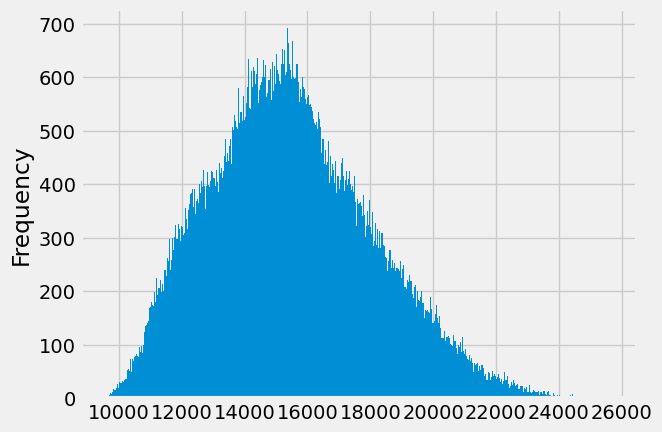

In [68]:
# Find outliers : 
df['AEP_MW'].plot(kind='hist', bins=500)

df = df.query('AEP_MW > 19_000').copy()

Time Series Cross Validation 